<a href="https://colab.research.google.com/github/jkarenko/Function-Approximation/blob/main/Function_Approximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

genetic algorithm to approximate a transfer function

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [60]:
target_neg = {
    -1: -.58,
    -.9: -.57,
    -.8: -.56,
    -.7: -.54,
    -.6: -.50,
    -.5: -.45,
    -.4: -.40,
    -.3: -.36,
    -.2: -.23,
    -.1: -.11,
    0: 0,
}
target_pos = {
    0: 0,
    .1: .11,
    .2: .26,
    .3: .39,
    .4: .54,
    .5: .64,
    .6: .82,
    .7: .86,
    .8: .87,
    .9: .88,
    1: .88
}

#list(target.values())

In [3]:
for i, k in enumerate({.1:.3, .4:.56}):
  print(i, k)

0 0.1
1 0.4


In [4]:
class Genome:
  def __init__(self, n) -> None:
    self.n = n
    self.fitness = float("inf")
    self.lookup_table = {}
    self.transfer_function = ""
  def _get_equation(self):
    equation = ""
    for nth in self.n:
      value = self.n[nth]
      equation = f" + {value} * X ** {nth}" + equation
    return equation
  def __str__(self):
    newline = "\n"
    return f"Function={self._get_equation()}\nfitness={self.fitness}\nValues from input:\n{f'{newline}'.join(list(map(lambda x: f'{x} -> {self.lookup_table[x]}', self.lookup_table.keys())))}"


In [5]:
def f(input, n):
  equation = ""
  for nth in n:
    value = n[nth]
    equation = f" + {value} * {input} ** {nth}" + equation
  return eval(equation)
#res = f(0.1, {1: .23, 2: .6, 3: .83})
#print(res)

In [6]:
def test_fitness(input, genome, target):
  results = {}
  for i in input:
    results[i] = f(i, genome.n)
  fitness = 0
  for in_val in results:
    out_val = results[in_val]
    target_val = target[in_val]
    if out_val < 0 and target_val < 0:
      fitness = fitness + abs(abs(target_val) - abs(out_val))
    elif out_val < 0 and target_val >= 0:
      fitness = fitness + target_val + abs(out_val)
    elif out_val >= 0 and target_val < 0:
      fitness = fitness + abs(target_val) + out_val
    else:
      fitness = fitness + abs(target_val - out_val)
  genome.fitness = fitness / len(target)
  genome.lookup_table = results
  return genome

In [7]:
def make_random_genome(order):
  n = {}
  for i in range(1, order + 1):
    n[i] = np.random.uniform(-1, 1)
  return Genome(n)
#make_random_genome(order=4).n

In [8]:
def new_genome_from_parents(p1, p2, mutation=.05):
  n = {}
  for i in p1.n:
    n[i] = np.random.choice((p1.n[i], p2.n[i])) * (1 + np.random.uniform(-1 * mutation, mutation))
  return Genome(n)
#new_genome_from_parents(make_random_genome(4), make_random_genome(4)).n

In [108]:
from IPython.core.display import Math
#input_values = np.round(np.arange(-1, 1, 0.1), decimals=2)

winner = {}
num_candidates = 100
num_generations = 100
num_of_best = int(np.floor(num_candidates/10))
num_mates_for_best = 10
order = 9

for index, target in enumerate([target_pos, target_neg]):
  input_values = target.keys()
  candidates = []
  for _ in range(0,num_candidates):
    candidates.append(make_random_genome(order))
  for generation in range(0, num_generations):

    for genome in candidates:
      genome = test_fitness(input_values, genome, target).fitness

    candidates.sort(key = lambda x: x.fitness)

    best_genomes = candidates[:num_of_best]

    # print(f"\nBest of generation {generation}: {best_genomes[0].fitness}")

    new_generation = []
    for i in range(0, num_of_best):
      for j in range(i + 1, i + num_mates_for_best):
        new_generation.append(new_genome_from_parents(best_genomes[i], candidates[j]))
      
    candidates = best_genomes + new_generation
    # print(len(candidates))

  winner[index] = candidates[0]
  print(f"Best genome after {num_generations} generations:")
  print(winner[index])
  for i, k in enumerate(target):
    print(f"{k} -> {target[k]}")

Best genome after 100 generations:
Function= + 0.11430987271415409 * X ** 9 + 0.5991616022582326 * X ** 8 + 0.10262975118846397 * X ** 7 + -0.6637466122617326 * X ** 6 + -0.4163592452246088 * X ** 5 + -0.5090546736210487 * X ** 4 + -0.2995417551601044 * X ** 3 + 0.8578616367206775 * X ** 2 + 1.094531028599062 * X ** 1
fitness=0.01013202583343596
Values from input:
0 -> 0.0
0.1 -> 0.11767646103442728
0.2 -> 0.2498370409690802
0.3 -> 0.39192426747322534
0.4 -> 0.5364763573243395
0.5 -> 0.6724555511636391
0.6 -> 0.7856190151999285
0.7 -> 0.8610957403618908
0.8 -> 0.8897403744234151
0.9 -> 0.8802839084176417
1 -> 0.8797916052130956
0 -> 0
0.1 -> 0.11
0.2 -> 0.26
0.3 -> 0.39
0.4 -> 0.54
0.5 -> 0.64
0.6 -> 0.82
0.7 -> 0.86
0.8 -> 0.87
0.9 -> 0.88
1 -> 0.88
Best genome after 100 generations:
Function= + 0.7726604541538957 * X ** 9 + -0.5880645118261537 * X ** 8 + -0.006806533227525455 * X ** 7 + -0.0061098964957593685 * X ** 6 + -0.10838725678954532 * X ** 5 + -0.45507318673663777 * X ** 4 + 

In [10]:
print(list(winner.lookup_table.values()))

[-0.6251083449231882, -0.693911203832599, -0.6941275892743072, -0.648397527200095, -0.5741431108784485, -0.48417253709022323, -0.38728414232430886, -0.2888704389732945, -0.19152215152913393, -0.09563225277880995, 0.0, 0.09563225277880995, 0.19152215152913393, 0.2888704389732945, 0.38728414232430886, 0.48417253709022323, 0.5741431108784485, 0.648397527200095, 0.6941275892743072, 0.693911203832599, 0.6251083449231882]


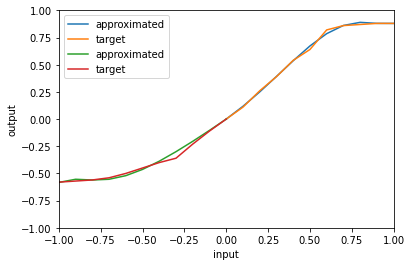

In [109]:
input_pos = list(winner[0].lookup_table.keys())
output_pos = list(winner[0].lookup_table.values())
target_values_pos = list(target_pos.values())

input_neg = list(winner[1].lookup_table.keys())
output_neg = list(winner[1].lookup_table.values())
target_values_neg = list(target_neg.values())

plt.plot(input_pos, output_pos, label="approximated")
plt.plot(input_pos, target_values_pos, label="target")

plt.plot(input_neg, output_neg, label="approximated")
plt.plot(input_neg, target_values_neg, label="target")

plt.legend()

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.ylabel("output")
plt.xlabel("input")
plt.show()